<a href="https://colab.research.google.com/github/Alenushka2013/Coursera/blob/master/240191_6_3_Time_Series_Analysis_%D0%9C%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B8_%D1%86%D0%B5%D0%BD%D1%8B_%D0%B0%D0%BA%D1%86%D0%B8%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогнозирование временных рядов на примере акций компании

# 📊 **План семинара**:

## 1. Загрузка данных
* Скачаем исторические данные по выбранной акции с помощью `alphavantage`.


## 2. Разделение выборки
* Разделим данные на обучающую и тестовую выборки для оценки качества прогноза.

## 3. Исследование временного ряда

### 3.1 Анализ тренда
* Определим наличие и форму тренда в данных: линейный, экспоненциальный и т.д.

### 3.2 Анализ сезонности и циклов
* Проверим, присутствует ли в данных сезонность и цикличность.

### 3.3 Проверка стационарности
* Проанализируем остатки на стационарность с помощью статистических тестов:
  - Тест Дики-Фуллера (ADF)
  - Оценим среднии и дисперсии на 2-х частях данных


## 4. Построение модели ARIMA
* Выберем параметры (p, d, q) на основе ACF/PACF.
* Обучим модель ARIMA на обучающей выборке.
* Оценим её адекватность.


## 5. Прогнозирование с использованием Prophet
* Используем модель Prophet от Facebook для построения прогноза.
* Сравним её результаты с ARIMA.


## 💻 Импорт библиотек

In [1]:
!pip install numpy==1.26.4 pmdarima catboost --quite


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --quite


In [2]:
import pmdarima as pm
from prophet import Prophet
from catboost import CatBoostRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import f_oneway, ttest_ind

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import requests
import warnings
# from config import api_key
from tqdm.notebook import tqdm

In [3]:
import pmdarima as pm

In [4]:
SEED = 17
np.random.seed(SEED)
warnings.filterwarnings("ignore")

## 🔐 Инструкция по получению API-ключа для Alpha Vantage

---

1. Перейдите на сайт: [https://www.alphavantage.co/](https://www.alphavantage.co/)
2. Нажмите кнопку **GET FREE API KEY**
3. Заполните форму:
   - Укажите, кто вы: *Student*, *Software Engineer*, *Investor* и т.д.  
     (Можно просто выбрать **Student**)
   - Впишите организацию, в которой учитесь или работаете
   - Укажите ваш **email**
4. Подтвердите регистрацию, если потребуется

---

🎉 **Готово!** Вы получили свой **API-ключ**, который теперь можно использовать для отправки запросов и загрузки данных.


# Загрузим данные по выбранной нами акции

In [5]:
api_key = '8KPVFRER3Q0OQBDT'
ticker = 'GOOGL'  # Указываем тикер акции
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_WEEKLY&symbol={ticker}&apikey={api_key}&outputsize=full'  # Формируем URL для запроса данных
response = requests.get(url)  # Отправляем GET-запрос к API
data = response.json()  # Преобразуем ответ в формат JSON
print(data)

{'Meta Data': {'1. Information': 'Weekly Prices (open, high, low, close) and Volumes', '2. Symbol': 'GOOGL', '3. Last Refreshed': '2025-08-14', '4. Time Zone': 'US/Eastern'}, 'Weekly Time Series': {'2025-08-14': {'1. open': '200.9350', '2. high': '204.5300', '3. low': '197.5101', '4. close': '202.9400', '5. volume': '109830236'}, '2025-08-08': {'1. open': '190.2900', '2. high': '202.6100', '3. low': '190.1200', '4. close': '201.4200', '5. volume': '150196235'}, '2025-08-01': {'1. open': '193.6500', '2. high': '197.5999', '3. low': '187.8200', '4. close': '189.1300', '5. volume': '198135406'}, '2025-07-25': {'1. open': '186.2500', '2. high': '197.9500', '3. low': '186.1500', '4. close': '193.1800', '5. volume': '263812842'}, '2025-07-18': {'1. open': '181.0100', '2. high': '186.4200', '3. low': '179.6800', '4. close': '185.0600', '5. volume': '165096150'}, '2025-07-11': {'1. open': '179.0600', '2. high': '181.4300', '3. low': '172.7700', '4. close': '180.1900', '5. volume': '181179085'}

In [6]:
data = pd.DataFrame.from_dict(data['Weekly Time Series'], orient='index', columns=['4. close'])
data.index.name = 'date'
data.reset_index(inplace=True)

In [7]:
data.columns = ['date', 'close']  # Переименовываем столбцы
data['close'] = data['close'].astype(float)  # Преобразуем тип данных столбца 'close' в float
data['date'] = pd.to_datetime(data['date'])  # Преобразуем тип данных столбца 'date' в datetime

In [8]:
data = data.sort_values(by='date').reset_index(drop=True).loc[:900]
data['t'] = data.index

In [9]:
data.head()

,date,close,t
0,2004-08-27,106.15,0
1,2004-09-03,100.01,1
2,2004-09-10,105.33,2
3,2004-09-17,117.49,3
4,2004-09-24,119.83,4


## 📈 Визуализация данных

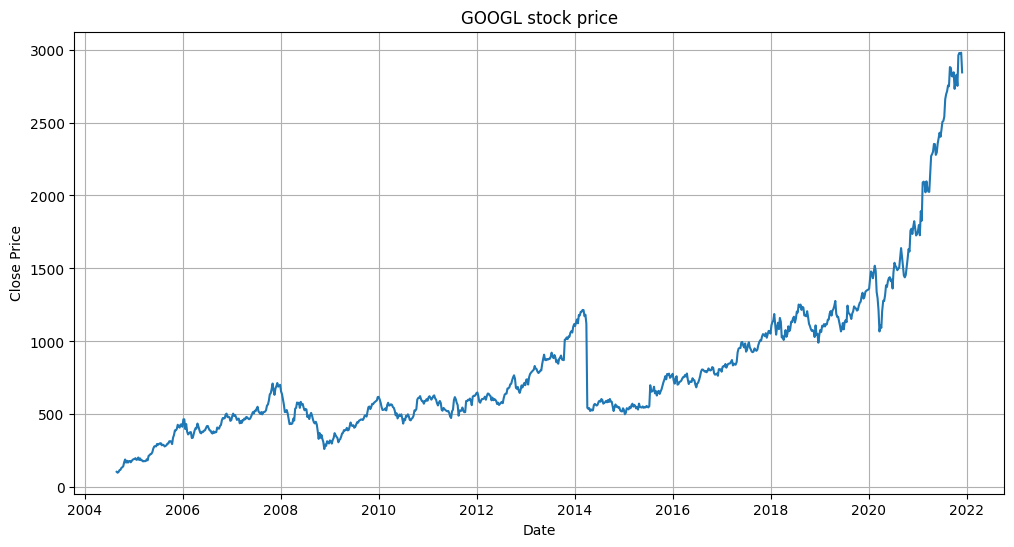

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['close'])
plt.title(f'{ticker} stock price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

# 🕘 Деление временного ряда на выборки: Train / Test

In [11]:
train_data, test_data = train_test_split(data, test_size=0.3, shuffle=False)  # Разделяем данные на обучающую+валидационную и тестовую выборки по времени

In [12]:
train_data

,date,close,t
0,2004-08-27,106.15,0
1,2004-09-03,100.01,1
2,2004-09-10,105.33,2
3,2004-09-17,117.49,3
4,2004-09-24,119.83,4
...,...,...,...
625,2016-08-19,799.65,625
626,2016-08-26,793.22,626
627,2016-09-02,796.87,627
628,2016-09-09,788.48,628


In [13]:
X_train = train_data[['t']]
y_train = train_data['close']

X_test = test_data[['t']]
y_test = test_data['close']

In [14]:
print(f'Train shape: {X_train.shape}, {y_train.shape}')
print(f'Test shape: {X_test.shape}, {y_test.shape}')

Train shape: (630, 1), (630,)
Test shape: (271, 1), (271,)


In [15]:
X_train.head(5) #То есть данные, на которых строится предсказание - это момент времени t

,t
0,0
1,1
2,2
3,3
4,4


In [16]:
y_train.head(5) # Цена, которую мы хотим предсказать - это цена закрытия акции в момент времени t

,close
0,106.15
1,100.01
2,105.33
3,117.49
4,119.83


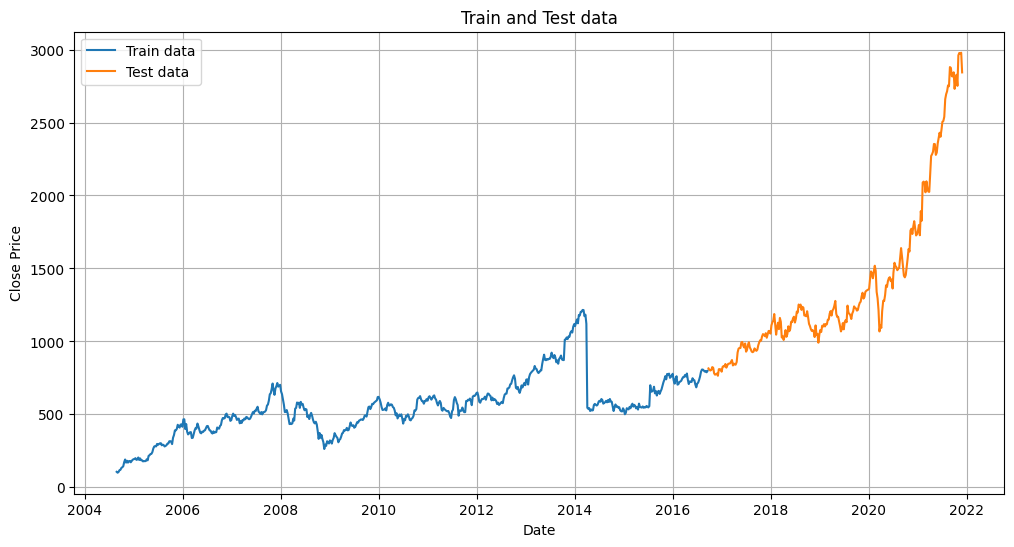

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(train_data['date'], train_data['close'], label='Train data')
plt.plot(test_data['date'], test_data['close'], label='Test data')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Train and Test data')
plt.legend()
plt.grid(True)
plt.show()

## 📏 В качестве метрики будем использовать MAE

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|
$$

In [18]:
from sklearn.metrics import mean_absolute_error

def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# 🔁 Базовая модель (Baseline): лаг на 1 день

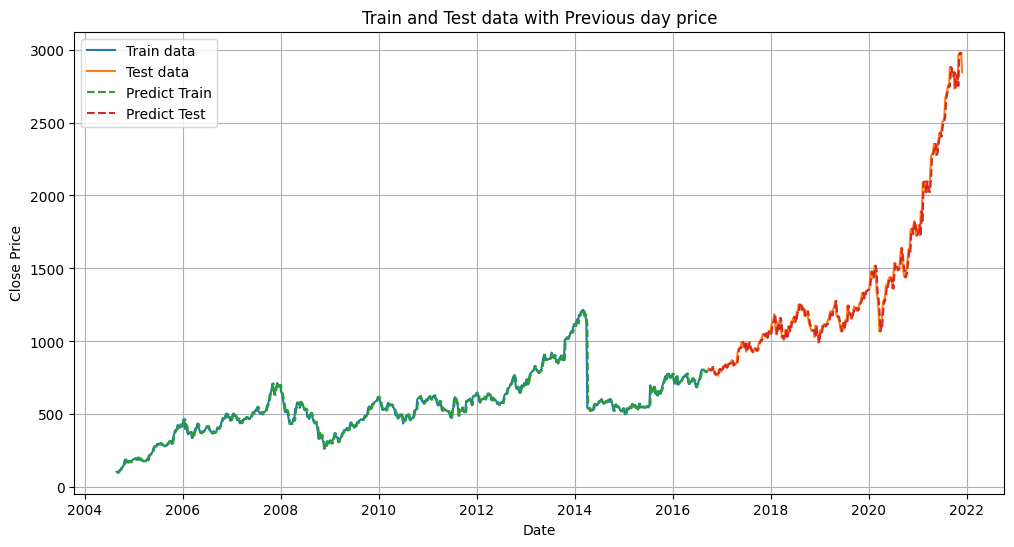

MAE Previos Day Train: 17.17
MAE Previos Day Test: 34.28


In [19]:
# Сдвигаем данные на один день назад и удаляем пропущенные значения
y_train_previous = train_data['close'].shift(1).dropna()
y_test_previous = test_data['close'].shift(1).dropna()

plt.figure(figsize=(12, 6))
plt.plot(train_data['date'], train_data['close'], label='Train data')
plt.plot(test_data['date'], test_data['close'], label='Test data')
plt.plot(train_data['date'][1:], y_train_previous, label='Predict Train', linestyle='--')
plt.plot(test_data['date'][1:], y_test_previous, label='Predict Test', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Train and Test data with Previous day price')
plt.legend()
plt.grid(True)
plt.show()

print(f'MAE Previos Day Train: {calculate_mae(y_train[1:], y_train_previous):.2f}')
print(f'MAE Previos Day Test: {calculate_mae(y_test[1:], y_test_previous):.2f}')

# 🔍 Подбор модели тренда

## Линейный тренд

$$
\hat{y}_t = \beta_0 + \beta_1 \cdot t
$$


In [20]:
linear_trend = LinearRegression()
linear_trend.fit(X_train, y_train)

LinearRegression()

In [21]:
y_train_pred = linear_trend.predict(X_train)
y_test_pred = linear_trend.predict(X_test)

In [22]:
all_predictions = np.concatenate([y_train_pred, y_test_pred], axis=0).flatten()  # объединение всех предсказаний и вытаскивание в одномерный массив
all_dates = np.concatenate([train_data['date'], test_data['date']], axis=0)  # объединение всех дат

In [23]:
linear_trend_pred = pd.DataFrame({'date': all_dates, 'close_predict': all_predictions}) #сохраним для дальнейшего сравнения с другими трендами
linear_trend_pred.head()

,date,close_predict
0,2004-08-27,302.972414
1,2004-09-03,303.770758
2,2004-09-10,304.569101
3,2004-09-17,305.367445
4,2004-09-24,306.165789


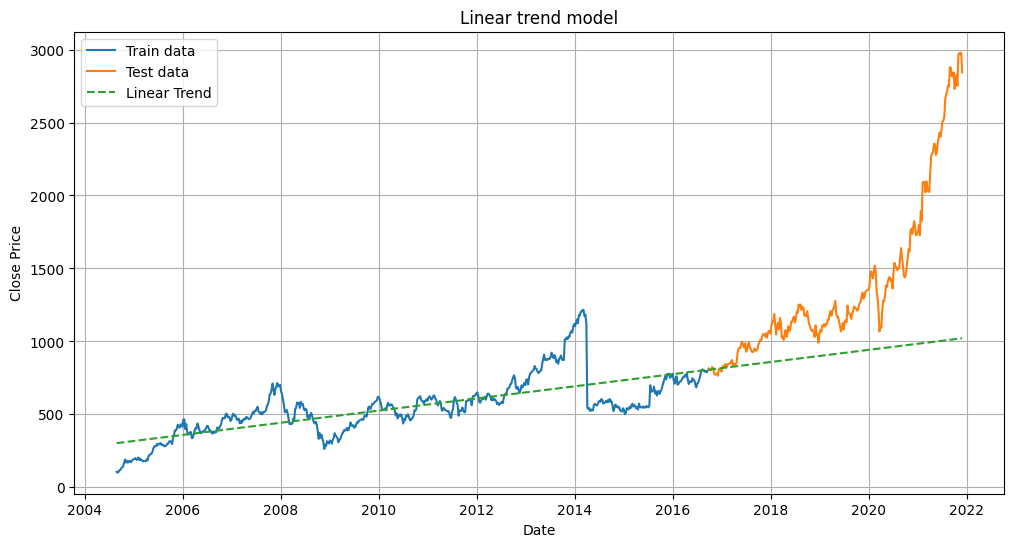

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(train_data['date'], train_data['close'], label='Train data')
plt.plot(test_data['date'], test_data['close'], label='Test data')
plt.plot(linear_trend_pred['date'], linear_trend_pred['close_predict'], label = 'Linear Trend', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Linear trend model')
plt.legend()
plt.grid(True)
plt.show()

### Проверим, правильно ли работает ```наш расчёт``` mae в сравнении с версией из ```sklearn```?

In [25]:
# Проверка, что собственная функция calculate_mae даёт такой же результат, как и стандартная из sklearn
assert calculate_mae(y_train, y_train_pred) == mean_absolute_error(y_train, y_train_pred)
assert calculate_mae(y_test, y_test_pred) == mean_absolute_error(y_test, y_test_pred)

#### Все метрики совпали, значит функция работает ```правильно```

In [26]:
print(f'MAE Linear Trend for train: {calculate_mae(y_train, y_train_pred):.2f}')
print(f'MAE Linear Trend for test: {calculate_mae(y_test, y_test_pred):.2f}')

MAE Linear Trend for train: 99.71
MAE Linear Trend for test: 471.76


## Полиномиальный тренд

$$
\hat{y}_t = \beta_1 \cdot t + \beta_2 \cdot t^2 + \dots + \beta_n \cdot t^n
$$

In [27]:
def polynomial_features(X, degree):
    # Генерируем имена признаков: t_1, t_2, ..., t_degree
    columns = [f't_{i+1}' for i in range(degree)]

    # Преобразуем входной вектор X в полиномиальные признаки указанной степени
    # include_bias=False исключает лишний столбец со значением 1 (сдвиг)
    return pd.DataFrame(
        PolynomialFeatures(degree=degree, include_bias=False).fit_transform(X),
        columns=columns
    )

# Пример вызова функции для построения признаков 1-й, 2-й и 3-й степени
polynomial_features(X_train, degree=3)


,t_1,t_2,t_3
0,0.0,0.0,0.0
1,1.0,1.0,1.0
2,2.0,4.0,8.0
3,3.0,9.0,27.0
4,4.0,16.0,64.0
...,...,...,...
625,625.0,390625.0,244140625.0
626,626.0,391876.0,245314376.0
627,627.0,393129.0,246491883.0
628,628.0,394384.0,247673152.0


### 🎯 Подбор оптимальной степени полинома (`degree`) по валидационной выборке

In [28]:
degrees = [2, 3, 4]
results = {}

for degree in tqdm(degrees):
    # Генерация полиномиальных признаков для обучающей, валидационной и тестовой выборок
    poly_X_train = polynomial_features(X_train, degree)
    poly_X_test = polynomial_features(X_test, degree)

    # Инициализация и обучение модели линейной регрессии на полиномиальных признаках
    poly_model = LinearRegression()
    poly_model.fit(poly_X_train, y_train)

    # Предсказание с использованием обученной модели для всех наборов данных
    y_train_pred = poly_model.predict(poly_X_train)
    y_test_pred = poly_model.predict(poly_X_test)

    # Объединение предсказаний и дат для построения графика
    all_predictions = np.concatenate([y_train_pred, y_test_pred], axis=0).flatten()
    all_dates = np.concatenate([train_data['date'], test_data['date']], axis=0)

    # Сохранение mae и предсказаний в словаре результатов
    results[degree] = {
        'train_mae': calculate_mae(y_train, y_train_pred),
        'test_mae': calculate_mae(y_test, y_test_pred),
        'all_predictions': all_predictions,
        'model': poly_model
    }

  0%|          | 0/3 [00:00<?, ?it/s]

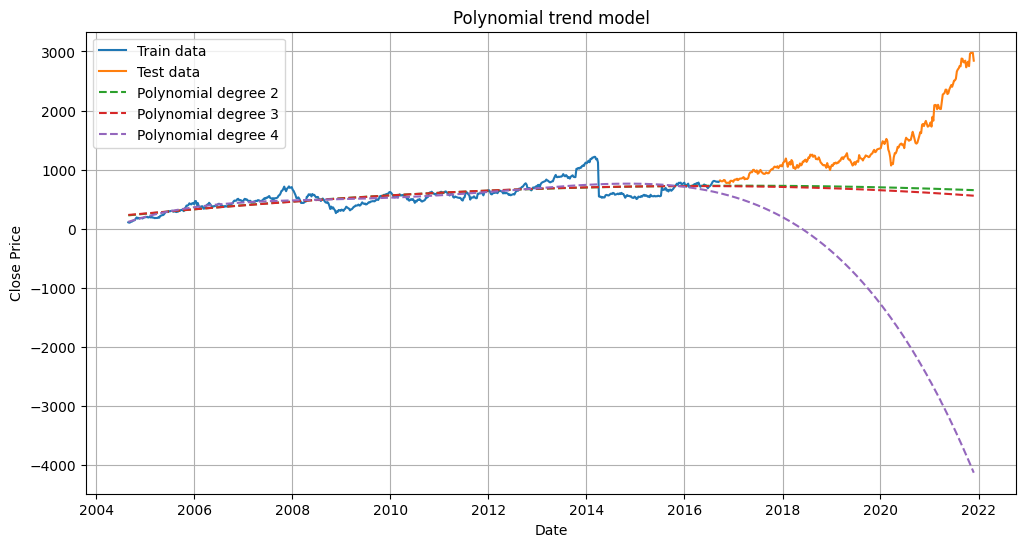

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(train_data['date'], train_data['close'], label='Train data')
plt.plot(test_data['date'], test_data['close'], label='Test data')
for degree, result in results.items(): # перебираем все результаты
    plt.plot(all_dates, result['all_predictions'], label=f'Polynomial degree {degree}', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Polynomial trend model')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
optimap_degree = min(results, key=lambda x: results[x]['test_mae'])
polynomial_trend = pd.DataFrame({'date': all_dates, 'close_predict': results[optimap_degree]['all_predictions']})

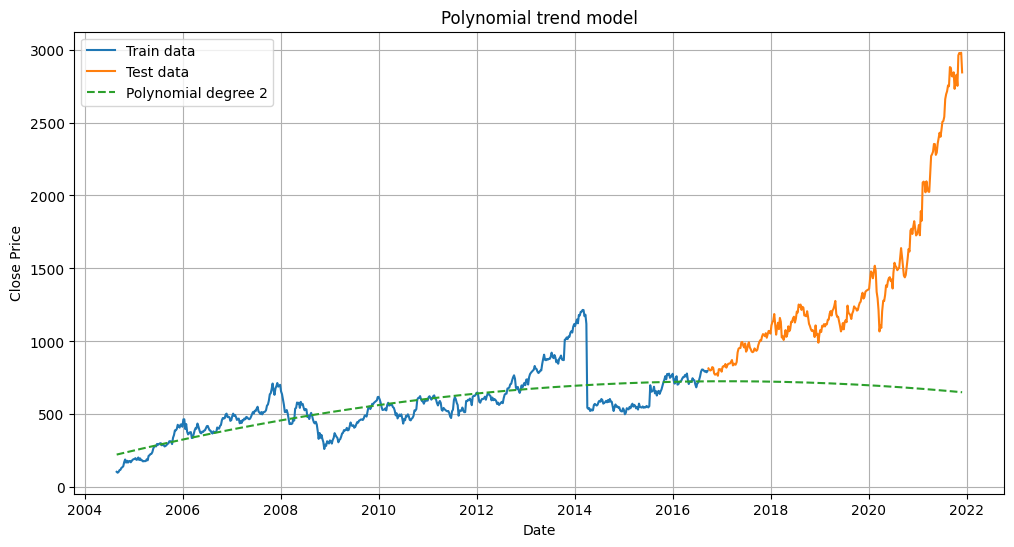

Optimal polynomial degree: 2
MAE Polynomial Trend for train: 95.50
MAE Polynomial Trend for test: 680.12
Model params
b1 = 1.54949
b2 = -0.00119
b0 = 224.35193977232188


In [31]:
plt.figure(figsize=(12, 6))
plt.plot(train_data['date'], train_data['close'], label='Train data')
plt.plot(test_data['date'], test_data['close'], label='Test data')
plt.plot(polynomial_trend['date'], polynomial_trend['close_predict'], label=f'Polynomial degree {optimap_degree}', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Polynomial trend model')
plt.legend()
plt.grid(True)
plt.show()

print(f'Optimal polynomial degree: {optimap_degree}')
print('=======')

print(f'MAE Polynomial Trend for train: {results[optimap_degree]["train_mae"]:.2f}')
print(f'MAE Polynomial Trend for test: {results[optimap_degree]["test_mae"]:.2f}')

print('=======')
print('Model params')
model = results[optimap_degree]['model']
for i, param in enumerate(model.coef_):
    print(f'b{i+1} = {param:.5f}')
print(f'b0 = {model.intercept_}')

## Экспоненциальный тренд

### 📈 Построение экспоненциального тренда через линейную регрессию

Допустим, мы предполагаем, что поведение временного ряда подчиняется **экспоненциальному тренду** следующего вида:

### 🧩 Шаг 1: Экспоненциальная модель

$$
\hat{y}(t) = \alpha \cdot e^{\beta t}
$$

где:
- $\hat{y}(t)$ — значение ряда в момент времени $t$,
- $\alpha > 0$ — начальное значение (уровень),
- $\beta$ — темп роста (если $\beta > 0$) или убывания (если $\beta < 0$).

---

### 🔄 Шаг 2: Линеаризация модели

Применим натуральный логарифм к обеим частям уравнения:

$$
\ln \hat{y}(t) = \ln(\alpha \cdot e^{\beta t}) = \ln(\alpha) + \beta t
$$

Введём обозначения:
- $Y = \ln y(t)$ — логарифм исходного ряда,
- $\beta_0 = \ln \alpha$ — свободный коэффициент.

Получаем **линейную модель**:

$$
Y = \beta_0 + \beta t
$$

---

### 📊 Шаг 3: Применение линейной регрессии

Теперь можно использовать **метод линейной регрессии** для оценки параметров модели:

- **Независимая переменная**: $t$ — момент времени,
- **Зависимая переменная**: $Y = \ln y(t)$ — логарифм исходных значений.

Модель в стандартной форме:
$$
Y = \beta_0 + \beta t + \varepsilon
$$

где $\varepsilon$ — случайная ошибка (остаток).

---

### ✅ Шаг 4: Обратное преобразование

После оценки коэффициентов линейной регрессии:
- Найдём $\alpha = e^{\beta_0}$,
- Получим итоговую модель:

$$
\hat{y}(t) = \alpha \cdot e^{\beta t}
$$

---


In [32]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [33]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train_log)

LinearRegression()

In [34]:
# Извлекаем параметры обученной линейной модели:
# beta_0 — это свободный член (intercept), log(alpha) в экспоненциальной модели
beta_0 = linear_model.intercept_

# beta_1 — коэффициент при t, отвечает за темп роста/убывания
beta_1 = linear_model.coef_[0]

# Преобразуем параметры из логарифмического масштаба:
# В экспоненциальной модели y = alpha * exp(beta * t), где alpha = exp(beta_0)
alpha = np.exp(beta_0)

# beta остаётся тем же, он — коэффициент в степени
beta = beta_1

In [35]:
# Вычисляем прогнозы на тренировочной выборке:
# модель имеет вид: y_hat = alpha * exp(beta * t)
y_train_pred = (alpha * np.exp(beta * X_train.values)).flatten()

# И на тестовой выборке
y_test_pred = (alpha * np.exp(beta * X_test.values)).flatten()

In [36]:
exp_concat = np.concatenate([y_train_pred, y_test_pred], axis=0).flatten()
exp_dates = np.concatenate([train_data['date'], test_data['date']], axis=0)

In [37]:
y_train_pred[:5]

array([304.29503085, 304.80482396, 305.31547113, 305.8269738 ,
       306.3393334 ])

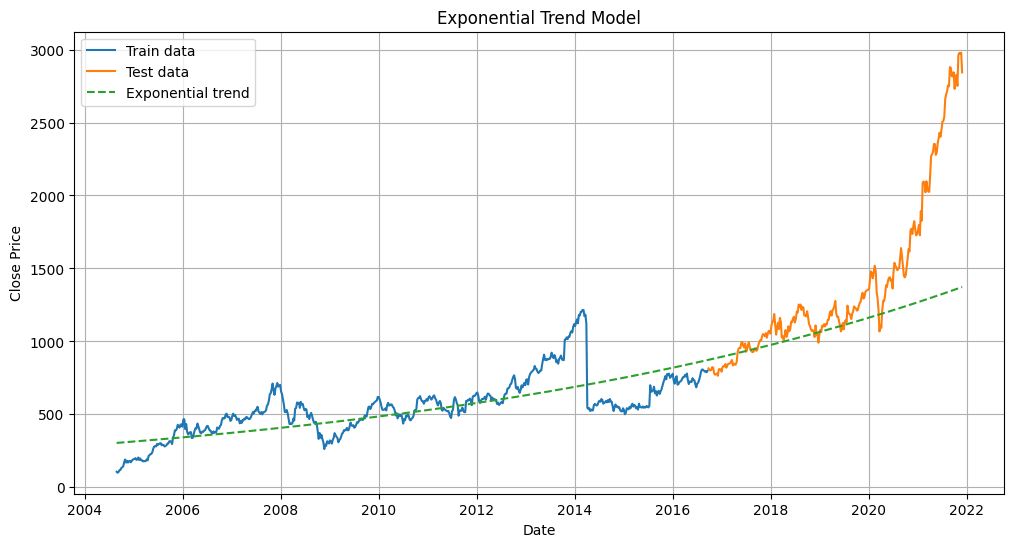

MAE Expomential Trend on train: 111.325
MAE Expomential Trend on test: 300.806


In [38]:
plt.figure(figsize=(12, 6))
plt.plot(train_data['date'], y_train, label='Train data')
plt.plot(test_data['date'], y_test, label='Test data')
plt.plot(exp_dates, exp_concat, label='Exponential trend', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Exponential Trend Model')
plt.legend()
plt.grid(True)
plt.show()

print(f'MAE Expomential Trend on train: {round(calculate_mae(y_train, y_train_pred), 3)}')
print(f'MAE Expomential Trend on test: {round(calculate_mae(y_test, y_test_pred), 3)}')

exp_trend_pred = pd.DataFrame({'date': exp_dates, 'close_predict': exp_concat})

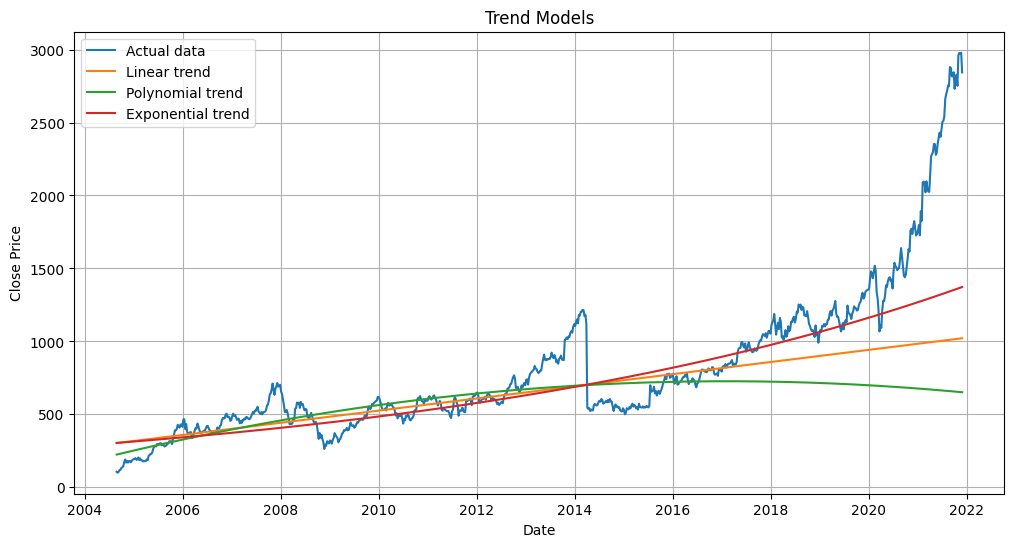

MAE Linear Trend: 111.325 300.806
MAE Polynomial Trend: 95.499 680.119
MAE Exponential Trend: 111.325 300.806


In [39]:
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['close'], label='Actual data')
plt.plot(linear_trend_pred['date'], linear_trend_pred['close_predict'], label='Linear trend')
plt.plot(polynomial_trend['date'], polynomial_trend['close_predict'], label='Polynomial trend')
plt.plot(exp_trend_pred['date'], exp_trend_pred['close_predict'], label='Exponential trend')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Trend Models')
plt.legend()
plt.grid(True)
plt.show()

print('MAE Linear Trend:', round(calculate_mae(y_train, y_train_pred), 3), round(calculate_mae(y_test, y_test_pred), 3))
print('MAE Polynomial Trend:', round(results[optimap_degree]['train_mae'], 3), round(results[optimap_degree]['test_mae'], 3))
print('MAE Exponential Trend:', round(calculate_mae(y_train, y_train_pred), 3), round(calculate_mae(y_test, y_test_pred), 3))

### ✅ Основные выводы:

- ⚠️ **Линейная и полнимальная модели** демонстрируют **высокую ошибку на валидации** — они не способны точно аппроксимировать сложные участки временного ряда.
- 🧮 **Экспоненциальная модель** показывает **лучшие результаты**, чем линейная и полиномиальная модели, остановимся на ней



# 🔁 Проверим наличие сезонности

In [40]:
train_data['chunk'] = 'train'
test_data['chunk'] = 'test'

all_data = pd.concat([train_data, test_data], axis=0)
all_data = all_data[['date', 'close', 'chunk']]
all_data['trend'] = exp_trend_pred['close_predict']

In [41]:
all_data['residuals_1'] = all_data['close'] - all_data['trend']

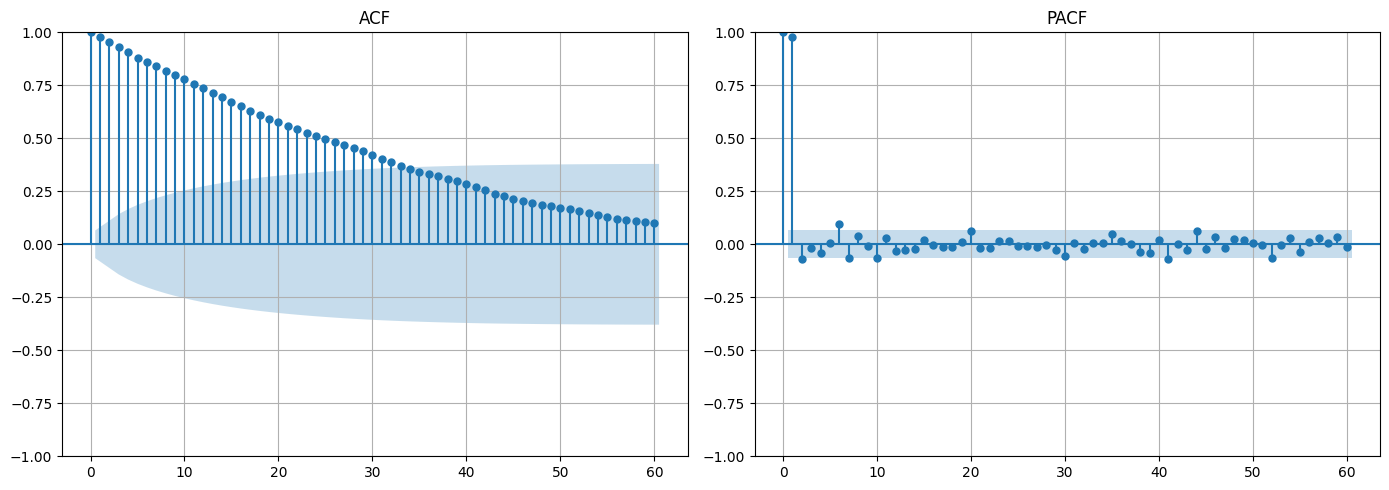

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(all_data['residuals_1'] , lags=60, ax=axs[0])
axs[0].set_title('ACF')
axs[0].grid(True)

plot_pacf(all_data['residuals_1'] , lags=60, ax=axs[1])
axs[1].set_title('PACF')
axs[1].grid(True)

plt.tight_layout()
plt.show()

## 🧩 Анализ графиков ACF и PACF:

- **ACF:** наблюдается **медленно убывающая автокорреляция**, но **нет выраженных пиков с периодичностью** (например, через каждые 12, 24, 36 лагов и т.д.), что характерно для сезонных рядов.
- **PACF:** также **отсутствуют регулярные всплески**
---

## ✅ Краткий вывод:

- ❌ **Сезонность в данных не выявлена.**  
- 📉 Остатки могут содержать долгосрочные зависимости, но **регулярной повторяющейся структуры нет**.


## 📉 Анализ стационарности временного ряда

t-тест и F-тест: Временной ряд не стационарен


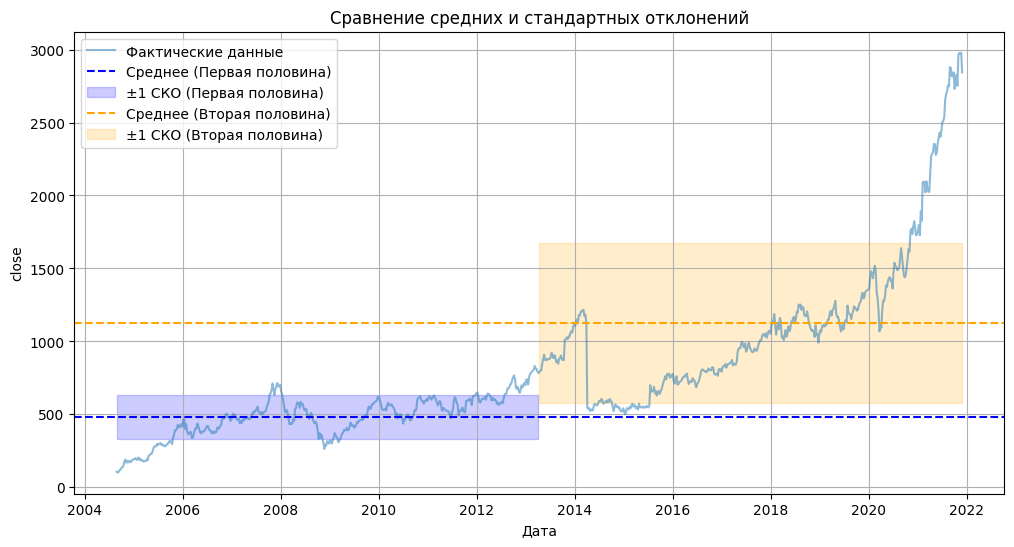

In [43]:
def test_stationarity_by_halves(all_data, columns_name, p=0.05):

    m = len(all_data) // 2  # Разделение на две половины
    a, b = all_data.iloc[:m][columns_name].dropna(), all_data.iloc[m:][columns_name].dropna()  # Получение значений для первой и второй половины
    mean_a, std_a = a.mean(), a.std()  # Среднее и СКО первой половины
    mean_b, std_b = b.mean(), b.std()  # Среднее и СКО второй половины
    t_p = ttest_ind(a, b, equal_var=False).pvalue  # p-значение t-теста
    f_p = f_oneway(a, b).pvalue  # p-значение F-теста

    print("t-тест и F-тест: Временной ряд стационарен" if t_p >= p and f_p >= p else "t-тест и F-тест: Временной ряд не стационарен")

    plt.figure(figsize=(12, 6))
    plt.plot(all_data['date'], all_data[columns_name], label='Фактические данные', alpha=0.5)
    plt.axhline(mean_a, color='blue', linestyle='--', label='Среднее (Первая половина)')
    plt.fill_between(all_data['date'][:m], mean_a - std_a, mean_a + std_a,
                     color='blue', alpha=0.2, label='±1 СКО (Первая половина)')
    plt.axhline(mean_b, color='orange', linestyle='--', label='Среднее (Вторая половина)')
    plt.fill_between(all_data['date'][m:], mean_b - std_b, mean_b + std_b,
                     color='orange', alpha=0.2, label='±1 СКО (Вторая половина)')
    plt.xlabel('Дата')
    plt.ylabel(columns_name)
    plt.title('Сравнение средних и стандартных отклонений')
    plt.legend()
    plt.grid(True)
    plt.show()

test_stationarity_by_halves(all_data,'close')

In [44]:
p_value = 0.05

adfuller_test = adfuller(all_data['close'])

if adfuller_test[1] < p_value:
    print('ADF: Временной ряд стацонарен')
else:
    print('ADF test: Временной ряд не стационарен')

ADF test: Временной ряд не стационарен


### Приведем к стационарности

In [45]:
def find_optimal_d(data, max_d=5, p_value=0.05):
    # Перебираем значения порядка дифференцирования от 0 до max_d
    for d in range(max_d + 1):
        # Выполняем d-кратное дифференцирование ряда
        diff_data = data.diff(d).dropna()

        # Если после дифференцирования весь ряд стал константой — пропускаем
        if diff_data.max() == diff_data.min():
            continue

        # Применяем ADF-тест (Augmented Dickey-Fuller) на стационарность
        adf_test = adfuller(diff_data)

        # Если p-value меньше уровня значимости — ряд стационарен, возвращаем d
        if adf_test[1] < p_value:
            return d
    return max_d

optimal_d = find_optimal_d(all_data['close'])
print(f'Оптимальный параметр d: {optimal_d}')

Оптимальный параметр d: 1


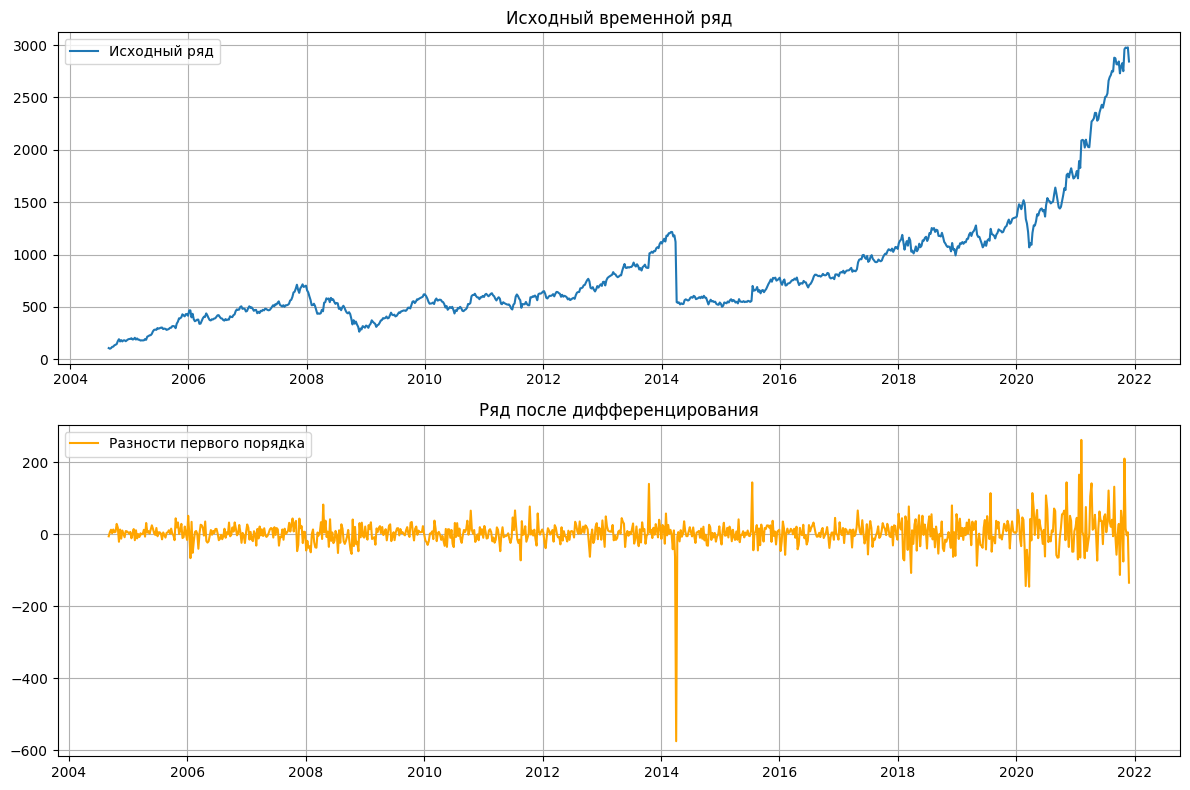

In [46]:
all_data['diff'] = all_data['close'].diff().dropna()

# Визуализация преобразованных рядов
plt.figure(figsize=(12, 8))

# Исходный ряд
plt.subplot(2, 1, 1)
plt.plot(all_data['date'], all_data['close'], label='Исходный ряд')
plt.title('Исходный временной ряд')
plt.grid(True)
plt.legend()

# Ряд после дифференцирования
plt.subplot(2, 1, 2)
plt.plot(all_data['date'], all_data['diff'], label='Разности первого порядка', color='orange')
plt.title('Ряд после дифференцирования')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [47]:
p_value = 0.05

adfuller_test = adfuller(all_data['diff'].dropna())

if adfuller_test[1] < p_value:
    print('ADF: Временной ряд стацонарен')
else:
    print('ADF test: Временной ряд не стационарен')

ADF: Временной ряд стацонарен


t-тест и F-тест: Временной ряд стационарен


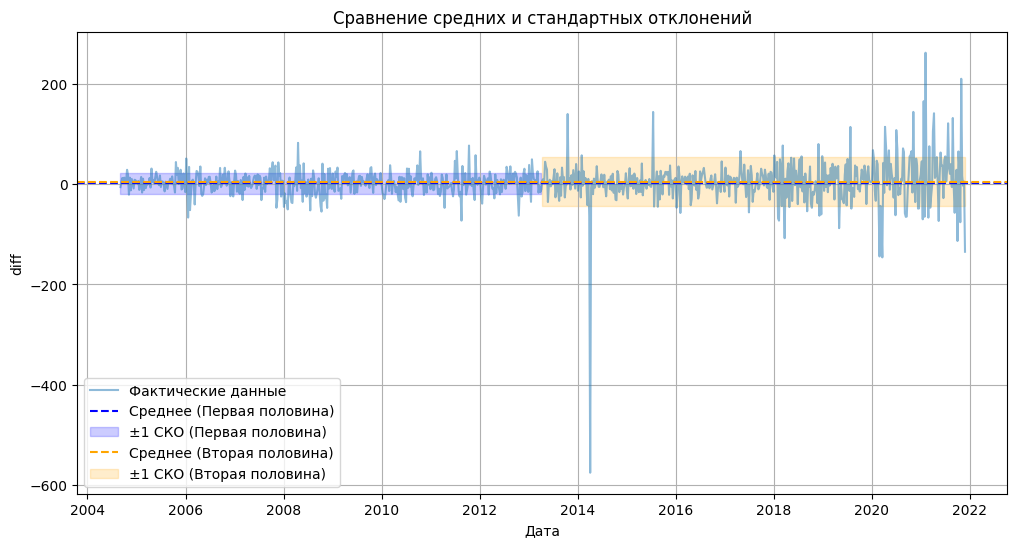

In [48]:
test_stationarity_by_halves(all_data, 'diff')

### 📉 Вывод по стационарности временного ряда

- 🔴 **Исходный ряд нестационарен** (t-тест, F-тест и ADF-тест не подтверждают стационарность)
- 🔁 **Оптимальный порядок дифференцирования: d = 1**


# 🐱📊 Построение модели ```CatBoost``` на остатках

In [49]:
catboost = CatBoostRegressor(
    iterations=100,
    depth=6,
    learning_rate=0.1,
    eval_metric='MAE',
    random_seed=SEED,
    verbose=0
)

def add_lags(df, target_col, lags):
    for lag in lags:
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    return df

all_data_lagged = all_data.copy()
all_data_lagged = add_lags(all_data_lagged, 'diff', lags=[1, 2, 3])

train_data = all_data_lagged[all_data_lagged['chunk'] == 'train'][['date', 'diff', 'lag_1', 'lag_2', 'lag_3', 'close']].dropna(subset='diff')
test_data = all_data_lagged[all_data_lagged['chunk'] == 'test'][['date', 'diff', 'lag_1', 'lag_2', 'lag_3', 'close']].dropna(subset='diff')

X_train = train_data[['lag_1', 'lag_2', 'lag_3']]
y_train = train_data['diff']

X_test = test_data[['lag_1', 'lag_2', 'lag_3']]
y_test = test_data['diff']

X_test.head()

,lag_1,lag_2,lag_3
630,9.49,-8.39,3.65
631,16.99,9.49,-8.39
632,-10.90,16.99,9.49
633,-3.35,-10.90,16.99
634,3.89,-3.35,-10.90


In [50]:
catboost.fit(X_train, y_train, verbose=100)
y_train_pred = catboost.predict(X_train)
y_test_pred = catboost.predict(X_test)
y_train_pred[:5] # Предсказание на обучающей выборке

0:	learn: 17.0043511	total: 48ms	remaining: 4.75s
99:	learn: 14.2738131	total: 145ms	remaining: 0us


array([-10.95802852,   6.20798753,   2.56403001,  -0.79892145,
         3.63905393])

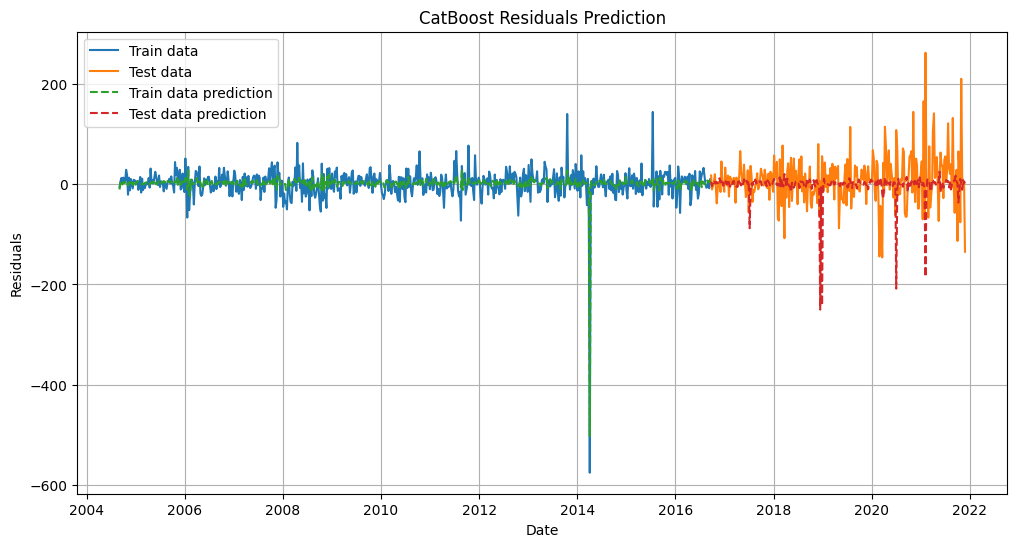

MAE CatBoost on train residuals: 14.274
MAE CatBoost on test residuals: 38.634


In [51]:
plt.figure(figsize=(12, 6))
plt.plot(train_data['date'], train_data['diff'], label='Train data')
plt.plot(test_data['date'], test_data['diff'], label='Test data')
plt.plot(train_data['date'], y_train_pred, label='Train data prediction', linestyle='--')
plt.plot(test_data['date'], y_test_pred, label='Test data prediction', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('CatBoost Residuals Prediction')
plt.legend()
plt.grid(True)
plt.show()

print(f'MAE CatBoost on train residuals: {round(calculate_mae(y_train, y_train_pred), 3)}')
print(f'MAE CatBoost on test residuals: {round(calculate_mae(y_test, y_test_pred), 3)}')

### 📌 Итог предсказания модели `CatBoost` + `Экспоненциальный тренд`:

* Модель достаточно хорошо аппроксимирует данные, однако **в комбинации с экспоненциальным трендом** справляется хуже: возникает переобучение на исторический тренд или нарушение общей динамики.
* Поскольку `CatBoost` — это бустинг на деревьях решений, модель **не умеет экстраполировать** за пределы обучающего диапазона.
  Поэтому она не способна прогнозировать значения **выше тех**, что были в обучающей выборке.

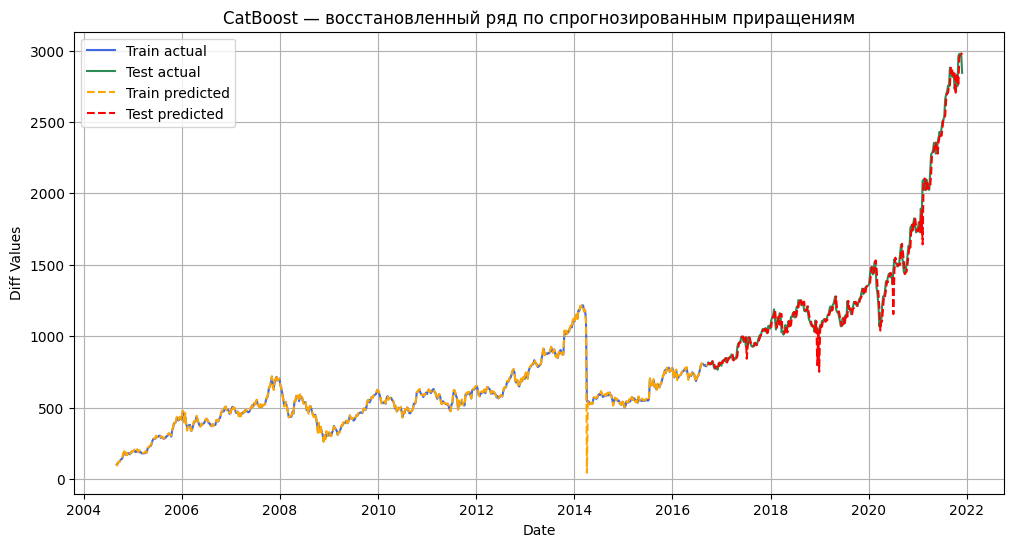

MAE (train): 4.878
MAE (test) : 38.634


In [52]:
y_train_diff_pred = catboost.predict(X_train)
y_test_diff_pred  = catboost.predict(X_test)

# Получаем исходные данные для восстановления ряда
# Используем истинные предыдущие значения для восстановления ряда
train_close_pred = []
for i, d in enumerate(y_train_diff_pred):
    # n = n - a + diff: используем фактическое значение и добавляем предсказанную разницу
    pred_value = train_data['close'].iloc[i] + d
    train_close_pred.append(pred_value)
train_close_pred = np.array(train_close_pred)

test_close_pred = []
for i, d in enumerate(y_test_diff_pred):
    # Для первого элемента используем последнее значение из обучающей выборки
    if i == 0:
        prev_value = train_data['close'].iloc[-1]
    else:
        prev_value = test_data['close'].iloc[i-1]
    # n = n - a + diff: используем фактическое значение и добавляем предсказанную разницу
    pred_value = prev_value + d
    test_close_pred.append(pred_value)
test_close_pred = np.array(test_close_pred)

plt.figure(figsize=(12, 6))

# фактическое
plt.plot(train_data['date'], train_data['close'], label='Train actual', color='royalblue')
plt.plot(test_data['date'],  test_data['close'],  label='Test actual',  color='seagreen')

# прогноз (восстановленный без тренда)
plt.plot(train_data['date'], train_close_pred, label='Train predicted', linestyle='--', color='orange')
plt.plot(test_data['date'],  test_close_pred,  label='Test predicted',  linestyle='--', color='red')

plt.xlabel('Date')
plt.ylabel('Diff Values')
plt.title('CatBoost — восстановленный ряд по спрогнозированным приращениям')
plt.legend()
plt.grid(True)
plt.show()

# ───────────────────────────────────────────────────────────
# 6.  MAE
# ───────────────────────────────────────────────────────────
mae_train = mean_absolute_error(train_data['close'], train_close_pred)
mae_test  = mean_absolute_error(test_data['close'],  test_close_pred)

print(f"MAE (train): {mae_train:.3f}")
print(f"MAE (test) : {mae_test:.3f}")

### 📌 Итог предсказания  ```CatBost``` + ```Экспонециальный тренд```:
- модль досточно хоршо апрксирует данные но в комбинации с трендом справлается не так хорошо
- модель не может предсказать значеинеи больше чем видела пэтому не сможет прогноизровать большие значения

# 🔧 Построение модели ```ARIMA```

## ⚙️ Выбор порядка AR и MA для модели ARIMA

- **AR (p = 1):**  
  На графике PACF значим только **первый лаг**, далее значения не выходят за доверительный интервал → выбираем `p = 1`.

- **MA (q = 0):**  
  График ACF показывает **постепенное убывание**, без резкого обрыва → компонент скользящего среднего не требуется → `q = 0`.


In [54]:
def fit_arima(train, order):
        model = ARIMA(train, order=order)
        model_fit = model.fit()
        return model_fit

def predictions_with_intervals(model_fit, data):
        predictions = []
        conf_intervals = []
        for t in tqdm(range(len(data))):
            forecast_result = model_fit.get_forecast(steps=1)
            yhat = forecast_result.predicted_mean.values[0]
            conf_int = forecast_result.conf_int().values[0]
            predictions.append(yhat)
            conf_intervals.append(conf_int)
            model_fit = model_fit.append([data.iloc[t]], refit=False)
        return predictions, conf_intervals

def arima_forecast(train_data, test_data, target_column, p, d, q):
    model_fit = fit_arima(train_data[target_column], order=(p, d, q))

    predictions_train, conf_intervals_train = predictions_with_intervals(model_fit, train_data[target_column])
    predictions_test, conf_intervals_test = predictions_with_intervals(model_fit, test_data[target_column])

    result = {
        'model_fit': model_fit,
        'train': {
            'predictions': predictions_train,
            'conf_intervals': conf_intervals_train
        },
        'test': {
            'predictions': predictions_test,
            'conf_intervals': conf_intervals_test
        }
    }

    return result

In [55]:
# Устанавливаем параметры модели ARIMA:
# p = порядок авторегрессии, d = порядок дифференцирования, q = порядок скользящего среднего
p = 1
d = 1
q = 0

train_data = all_data[all_data['chunk']=='train'][['date', 'close']].reset_index(drop=True)
test_data = all_data[all_data['chunk']=='test'][['date', 'close']].reset_index(drop=True)
result = arima_forecast(train_data, test_data, 'close', p, d, q)
print(result['model_fit'].summary())


  0%|          | 0/630 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  630
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -3069.108
Date:                Fri, 15 Aug 2025   AIC                           6142.217
Time:                        06:04:19   BIC                           6151.105
Sample:                             0   HQIC                          6145.670
                                - 630                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0507      0.054      0.943      0.346      -0.055       0.156
sigma2      1014.6888     13.458     75.396      0.000     988.311    1041.066
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [56]:
all_predictions_residuals = np.concatenate([result['train']['predictions'], result['test']['predictions']], axis=0)
all_dates_residuals = np.concatenate([train_data['date'],  test_data['date']], axis=0)

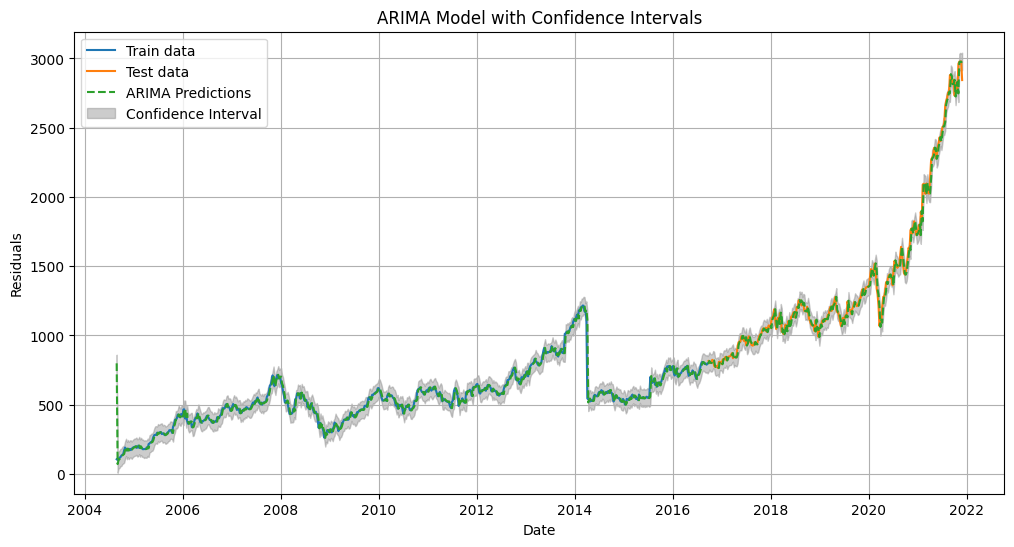

MAE ARIMA on train: 18.324
MAE ARIMA on test: 34.265


In [57]:
plt.figure(figsize=(12, 6))
plt.plot(train_data['date'], train_data['close'], label='Train data')
plt.plot(test_data['date'], test_data['close'], label='Test data')
plt.plot(all_dates_residuals, all_predictions_residuals, label='ARIMA Predictions', linestyle='--')

# Convert the confidence intervals to numpy arrays before indexing
train_conf_intervals = np.array(result['train']['conf_intervals'])
test_conf_intervals = np.array(result['test']['conf_intervals'])

plt.fill_between(all_dates_residuals,
                 np.concatenate([train_conf_intervals[:, 0], test_conf_intervals[:, 0]]),
                 np.concatenate([train_conf_intervals[:, 1], test_conf_intervals[:, 1]]),
                 color='gray', alpha=0.4, label='Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('ARIMA Model with Confidence Intervals')
plt.legend()
plt.grid(True)
plt.show()

y_train_pred_residuals = result['train']['predictions']
y_test_pred_residuals = result['test']['predictions']

print(f"MAE ARIMA on train: {round(calculate_mae(train_data['close'], y_train_pred_residuals), 3)}")
print(f"MAE ARIMA on test: {round(calculate_mae(test_data['close'], y_test_pred_residuals), 3)}")

### 📌 Итог:
> Модель **ARIMA(1,1,0)** хорошо прогнизирует данные на уровне baseline решения


## 🔧 Подбор параметров ARIMA с помощью pmdarima (auto_arima)

In [58]:
train_data = all_data[all_data['chunk']=='train'][['date', 'close']].reset_index(drop=True)
test_data = all_data[all_data['chunk']=='test'][['date',  'close']].reset_index(drop=True)

auto_arima = pm.auto_arima(
    train_data['close'],
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    d=1, trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

# Fit the model on the training data
auto_arima.fit(train_data['close'])

train_pred_residuals = auto_arima.predict_in_sample()

# Make predictions on test data
history = list(train_data['close'])
predictions_residuals = []

for t in tqdm(range(len(test_data))):
    model = auto_arima.fit(history)
    forecast = model.predict(n_periods=1)
    predictions_residuals.append(forecast[0])
    history.append(test_data['close'].iloc[t])

all_dates = np.concatenate([train_data['date'], test_data['date']], axis=0)
all_predictions_auto_arima_residuals = np.concatenate([train_pred_residuals, predictions_residuals], axis=0)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6143.088, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6143.539, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6143.537, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6141.838, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6145.082, Time=0.64 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.891 seconds


  0%|          | 0/271 [00:00<?, ?it/s]

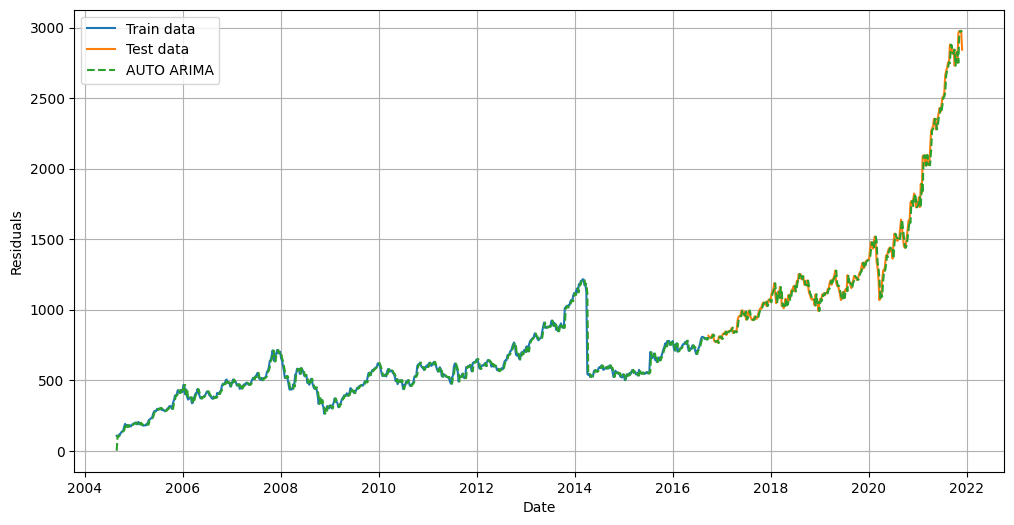

MAE AUTO ARIMA on train residuals: 17.307
MAE AUTO ARIMA on test residuals: 34.217


In [59]:
plt.figure(figsize=(12, 6))
plt.plot(train_data['date'], train_data['close'], label='Train data')
plt.plot(test_data['date'], test_data['close'], label='Test data')
plt.plot(all_dates, all_predictions_auto_arima_residuals, label=f'AUTO ARIMA', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

print(f'MAE AUTO ARIMA on train residuals: {round(calculate_mae(train_data["close"], train_pred_residuals), 3)}')
print(f'MAE AUTO ARIMA on test residuals: {round(calculate_mae(test_data["close"], predictions_residuals), 3)}')

### ⚠️ Почему `auto_arima` может подобрать параметры хуже, чем вручную

* `auto_arima` подбирает параметры модели, оптимизируя **информационный критерий AIC**,
  однако минимизация AIC **не означает** минимальную ошибку прогноза (например, MAE, MAPE и др.).
* Алгоритм не всегда учитывает **статистическую значимость коэффициентов**,
  поэтому важно **проверять значимость вручную** и при необходимости упростить модель.
* Кроме того, без правильной **предобработки данных** (например, логарифмирования, дифференцирования, устранения трендов и сезонностей) даже оптимальные параметры могут давать слабый прогноз.

# Обзор Prophet

In [60]:
train_data = all_data[all_data['chunk'] == 'train'].copy()
test_data = all_data[all_data['chunk'] == 'test'].copy()

In [61]:
train_data = train_data.rename(columns={'date': 'ds', 'close': 'y'})
test_data = test_data.rename(columns={'date': 'ds', 'close': 'y'})

In [62]:
y_cap = train_data['y'].max() * 1.2
train_data['cap'] = y_cap
test_data['cap'] = y_cap

In [63]:
model = Prophet(
    growth='logistic',
    changepoint_prior_scale=0.5,   # адаптивность к сменам тренда
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
)

model.fit(train_data)
future = model.make_future_dataframe(periods=len(test_data), freq='W')
future['cap'] = y_cap  # Ensure 'cap' column is included in the future dataframe
forecast = model.predict(future)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpehddcf_m/x2eqip96.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpehddcf_m/2halra4o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74413', 'data', 'file=/tmp/tmpehddcf_m/x2eqip96.json', 'init=/tmp/tmpehddcf_m/2halra4o.json', 'output', 'file=/tmp/tmpehddcf_m/prophet_modelpya5lk7d/prophet_model-20250815060537.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:05:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:05:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


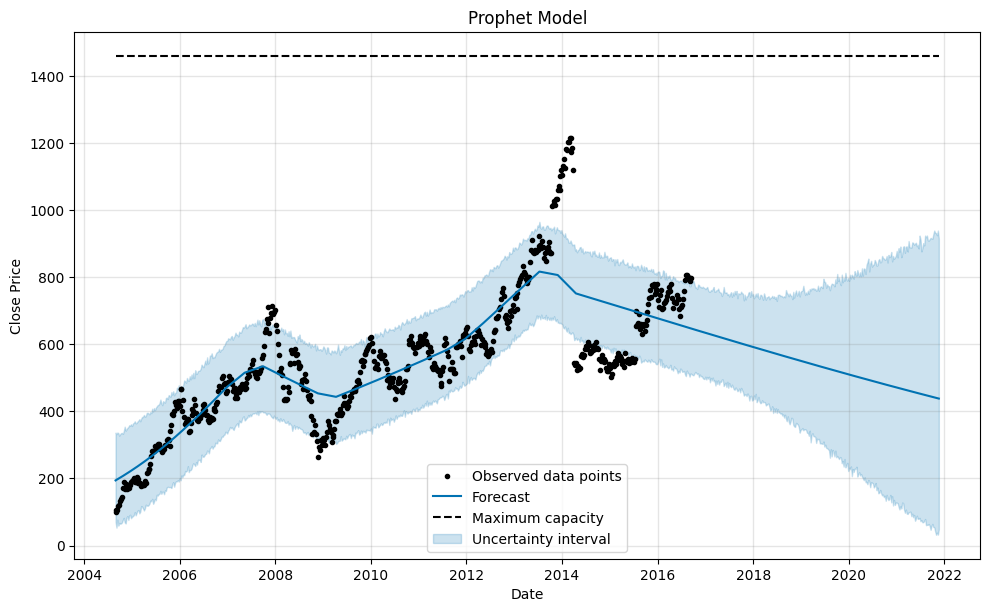

In [64]:
model.plot(forecast)
plt.title('Prophet Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.show()

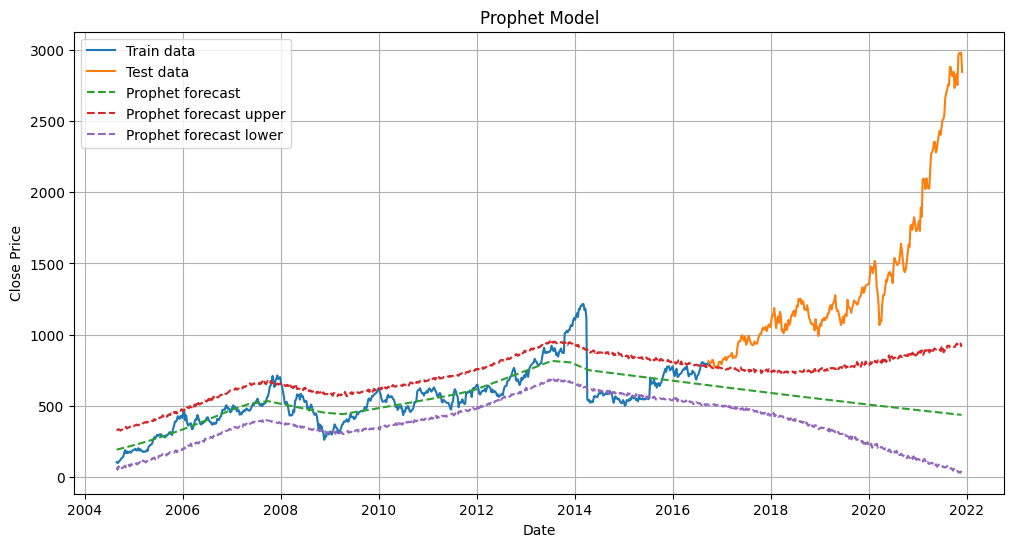

MAE Prophet on train data: 75.279
MAE Prophet on test data: 844.422


In [65]:
plt.figure(figsize=(12, 6))
plt.plot(train_data['ds'], train_data['y'], label='Train data')
plt.plot(test_data['ds'], test_data['y'], label='Test data')
plt.plot(forecast['ds'], forecast['yhat'], label='Prophet forecast', linestyle='--')
plt.plot(forecast['ds'], forecast['yhat_upper'], label='Prophet forecast upper', linestyle='--')
plt.plot(forecast['ds'], forecast['yhat_lower'], label='Prophet forecast lower', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Prophet Model')
plt.legend()
plt.grid(True)
plt.show()

print(f'MAE Prophet on train data: {round(calculate_mae(train_data["y"], forecast["yhat"][:len(train_data)]), 3)}')
print(f'MAE Prophet on test data: {round(calculate_mae(test_data["y"], forecast["yhat"][len(train_data):]), 3)}')

### 📌 Итог:
- Модель **не справилась с прогнозом экспоненциального роста** на тестовом отрезке.  
- Прогноз оказался слишком "плоским" — Prophet не уловил ускорение.

### 🧠 Выводы

* **Начинайте с простого.** Базовые модели часто дают достойные результаты и служат отличной отправной точкой для построения более сложных решений.
* **Стационарность — ключ к качественному прогнозу.** Проверяйте временные ряды на стационарность, так как нестабильные данные могут сильно исказить прогноз. При необходимости применяйте преобразования: дифференцирование, логарифмирование, устранение трендов.
* **Анализируйте значимость параметров.** Оценка статистической значимости коэффициентов помогает избежать переобучения, повысить интерпретируемость модели и улучшить её обобщающую способность.